# M-CARE (Maternal Causal Actionable Risk Engine)

## TabPFN
TabPFN (Tabular Prior-Fitted Network) is a groundbreaking foundation model for tabular data, leveraging a Transformer architecture pre-trained on a massive, diverse collection of synthetic datasets to internalize a strong, general prior over what constitutes a typical tabular classification or regression problem. This extensive pre-training allows TabPFN to bypass traditional, time-consuming model training and hyperparameter optimization steps for new tasks. Instead, when presented with a small-to-medium new dataset (ideally $\leq 50,000$ rows), it uses this new data as context and applies its pre-learned knowledge to make highly accurate predictions almost instantaneously, operating in an "in-context learning" manner similar to large language models. This unique working principle makes it a state-of-the-art solution for rapid, off-the-shelf deployment in scenarios where data is scarce or prediction speed is critical.

## SHAP-IQ
SHAP-IQ is a game-theoretic framework and Python library designed to quantify higher-order feature interactions (of any order) in machine learning models, extending beyond the individual feature attributions of standard SHAP. This allows users to uncover and visualize complex dependencies within black-box models that traditional "first-order" explainability methods fail to capture.

In [1]:
! pip install tabpfn dice-ml shapiq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.9/551.9 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from tabpfn import TabPFNClassifier
import dice_ml
import shapiq
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [3]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `thesis` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate w

## About the dataset

This dataset comprises detailed clinical, physiological, and historical health information collected from maternal patients to evaluate potential health risks during pregnancy.
It serves as a resource for developing predictive models aimed at identifying and managing high-risk pregnancies, providing insights into maternal health factors, and supporting personalized patient care.
The dataset is well-suited for research in obstetrics, predictive health modeling, and maternal healthcare management.

Acknowledgement

Mojumdar, Mayen Uddin ; Assaduzzaman, Md; Sarker, Dhiman; Shifa, Hasin Arman; Sajeeb, Md. Anisul Haque; Bari , Shadikul; Chakraborty, Narayan Ranjan; Alam, Mohammad Jahangir (2024), “Maternal Health Risk Assessment Dataset”, Mendeley Data, V1, doi: [10.17632/p5w98dvbbk.1](https://)

In [5]:
# Load Data (Replace with your actual path)

df = pd.read_csv('/content/Dataset - Updated.csv')

display(df.head())

display(df.info())

display(df.describe())

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate,Risk Level
0,22,90.0,60.0,9.0,100,18.0,1.0,1.0,0,1,80.0,High
1,22,110.0,70.0,7.1,98,20.4,0.0,0.0,0,0,74.0,Low
2,27,110.0,70.0,7.5,98,23.0,1.0,0.0,0,0,72.0,Low
3,20,100.0,70.0,7.2,98,21.2,0.0,0.0,0,0,74.0,Low
4,20,90.0,60.0,7.5,98,19.7,0.0,0.0,0,0,74.0,Low


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     1205 non-null   int64  
 1   Systolic BP             1200 non-null   float64
 2   Diastolic               1201 non-null   float64
 3   BS                      1203 non-null   float64
 4   Body Temp               1205 non-null   int64  
 5   BMI                     1187 non-null   float64
 6   Previous Complications  1203 non-null   float64
 7   Preexisting Diabetes    1203 non-null   float64
 8   Gestational Diabetes    1205 non-null   int64  
 9   Mental Health           1205 non-null   int64  
 10  Heart Rate              1203 non-null   float64
 11  Risk Level              1187 non-null   object 
dtypes: float64(7), int64(4), object(1)
memory usage: 113.1+ KB


None

,Age,Systolic BP,Diastolic,BS,Body Temp,BMI,Previous Complications,Preexisting Diabetes,Gestational Diabetes,Mental Health,Heart Rate
count,1205.000000,1200.000000,1201.000000,1203.000000,1205.000000,1187.000000,1203.000000,1203.000000,1205.000000,1205.00000,1203.000000
mean,27.731950,116.819167,77.166528,7.501064,98.395851,23.315080,0.175395,0.288446,0.117842,0.33444,75.817124
std,12.571074,18.715502,14.305148,3.049522,1.088363,3.875682,0.380463,0.453228,0.322555,0.47199,7.227338
min,10.000000,70.000000,40.000000,3.000000,97.000000,0.000000,0.000000,0.000000,0.000000,0.00000,58.000000
25%,21.000000,100.000000,65.000000,6.000000,98.000000,20.450000,0.000000,0.000000,0.000000,0.00000,70.000000
50%,25.000000,120.000000,80.000000,6.900000,98.000000,23.000000,0.000000,0.000000,0.000000,0.00000,76.000000
75%,32.000000,130.000000,90.000000,7.900000,98.000000,25.000000,0.000000,1.000000,0.000000,1.00000,80.000000
max,325.000000,200.000000,140.000000,19.000000,103.000000,37.000000,1.000000,1.000000,1.000000,1.00000,92.000000


In [6]:
# Map Target: High -> 1, Low -> 0

df['Risk Level'] = df['Risk Level'].astype(str).str.strip().str.lower()
df['Risk Level'] = df['Risk Level'].map({'high': 1, 'low': 0})
df = df.dropna(subset=['Risk Level'])
df['Risk Level'] = df['Risk Level'].astype(int)

target_col = 'Risk Level'
feature_names = [c for c in df.columns if c != target_col]

X = df[feature_names]
y = df[target_col]

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## TabPFN Model

In [7]:
print("Training TabPFN (Transformer)...")
clf = TabPFNClassifier() # kept low for speed
clf.fit(X_train, y_train)

Training TabPFN (Transformer)...


tabpfn-v2.5-classifier-v2.5_default.ckpt:   0%|          | 0.00/42.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

TabPFNClassifier()

In [8]:
# predictions

y_pred = clf.predict(X_test)

## Evaluation

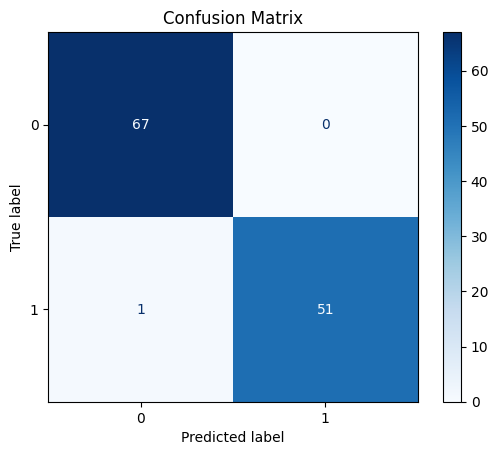


Accuracy Score: 0.9916


In [18]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_labels = clf.classes_ if hasattr(clf, 'classes_') else None

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy Score: {accuracy:.4f}")

## Interpretability: Explain TabPFN predictions with SHAP values and Dice-ML

In [9]:
# Select a High Risk Patient

# We want to explain a patient who is PREDICTED as High Risk (Class 1)
high_risk_indices = np.where(y_pred == 1)[0]

if len(high_risk_indices) == 0:
    print("No High Risk patients found in test set to analyze.")
else:
    idx_in_test = high_risk_indices[11] # can be any patient, we selected index 11
    patient_data_series = X_test.iloc[idx_in_test] # for SHAP
    patient_data_df = X_test.iloc[[idx_in_test]] # Keep as DataFrame for DiCE

    print(f"\nAnalyzing Patient Index: {idx_in_test}")
    print(f"Current Prediction: HIGH RISK")


Analyzing Patient Index: 28
Current Prediction: HIGH RISK


In [10]:
# SHAPIQ: Why?
print("\n--- [DIAGNOSIS] SHAPIQ EXPLANATION ---")

# Define a wrapper for probability of Class 1 (High Risk)
def predict_proba_positive(data_array):
    return clf.predict_proba(data_array)[:, 1]

# We explain the interactions for the "High Risk" class
explainer = shapiq.Explainer(
    model=predict_proba_positive,
    data=X_train.values,
    class_index=None # We are manually returning the proba for class 1 above
)

# Explain the specific patient
print("Calculating feature interactions")
explanation = explainer.explain(
    patient_data_series.values,
    budget=50  # Lower budget for demo speed; increase for precision
)


--- [DIAGNOSIS] SHAPIQ EXPLANATION ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(


Calculating feature interactions


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but TabPFNClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/

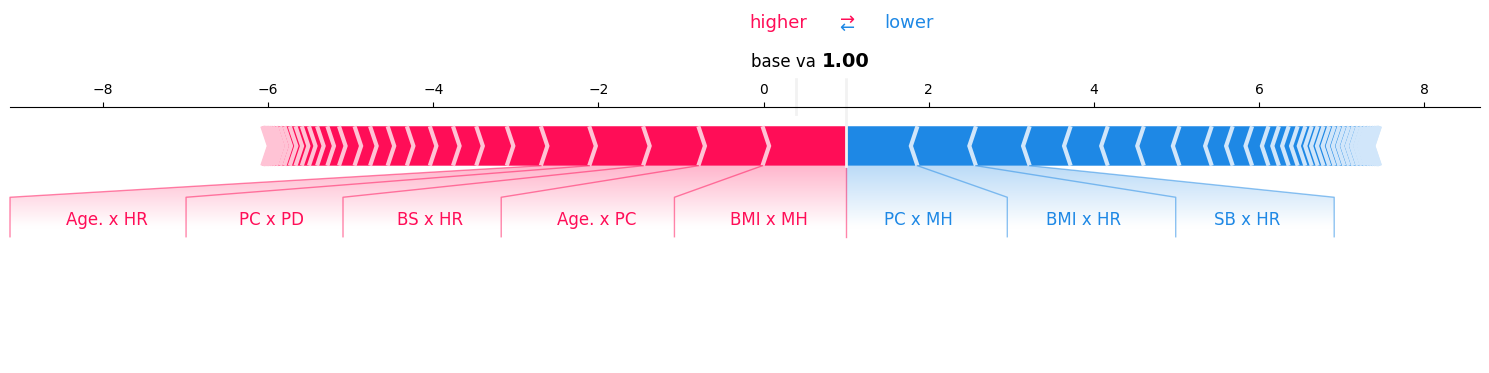

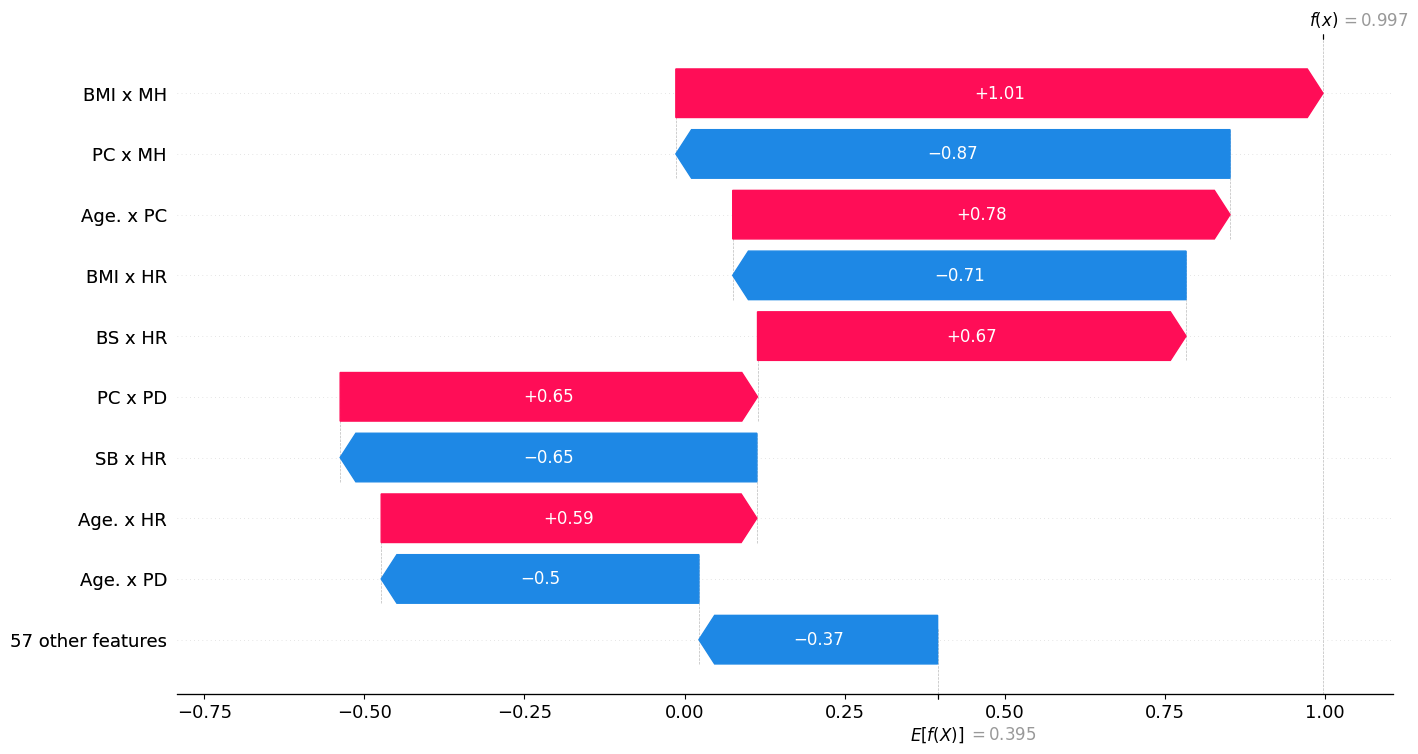

In [12]:
# Plot

explanation.plot_force(feature_names=X.columns.tolist())
plt.show()

explanation.plot_waterfall(feature_names=X.columns.tolist())
plt.show()

In [13]:
# DiCE: How to Fix?

print("\n--- [PRESCRIPTION] DiCE COUNTERFACTUALS ---")
print("Optimization Constraints: Locking History & Enforcing Normal Ranges...")

# Setup DiCE Data
d = dice_ml.Data(dataframe=df, continuous_features=feature_names, outcome_name=target_col)

# Setup DiCE Model
m = dice_ml.Model(model=clf, backend="sklearn")

# Initialize
exp = dice_ml.Dice(d, m, method="random")

# Define Clinical Constraints (Safety Bounds)
# Only allow changes to actionable features

actionable = ['Systolic BP', 'Diastolic', 'BS', 'BMI', 'Body Temp', 'Heart Rate']
valid_actionable = [c for c in actionable if c in X.columns]

# Define Medical Safety Ranges
safety_bounds = {
    'Systolic BP': [90, 120],
    'Diastolic': [60, 80],
    'BS': [3.9, 7.8],
    'BMI': [18.5, 24.9],
    'Body Temp': [97, 99]
}

# Filter bounds to only include columns present in data
valid_bounds = {k: v for k, v in safety_bounds.items() if k in valid_actionable}

# Generate Plan
dice_exp = exp.generate_counterfactuals(
    patient_data_df,
    total_CFs=1,
    desired_class=0,
    features_to_vary=valid_actionable,
    permitted_range=valid_bounds
)

# Interpreted Plan
cf_df = dice_exp.cf_examples_list[0].final_cfs_df
if not cf_df.empty:
    suggestion = cf_df.iloc[0]
    original = patient_data_series

    print(f"\nAI Doctor Prescription:")
    for col in valid_actionable:
        diff = suggestion[col] - original[col]
        if abs(diff) > 0.1:
            direction = "Reduce" if diff < 0 else "Increase"
            print(f"  - {direction} {col} by {abs(diff):.1f} (Target: {suggestion[col]:.1f})")
else:
    print("No medically safe path found for this patient.")


--- [PRESCRIPTION] DiCE COUNTERFACTUALS ---
Optimization Constraints: Locking History & Enforcing Normal Ranges...


100%|██████████| 1/1 [00:04<00:00,  4.29s/it]


AI Doctor Prescription:
  - Reduce Systolic BP by 12.2 (Target: 117.8)
  - Reduce BMI by 6.5 (Target: 21.0)


## Conclusions

Our analysis:

* **Dataset:** Utilized the **Mendely Maternal Health Risk Assessment** dataset with a binary target: High vs. Low Risk.
* **Model:** Employed **TabPFN (Tabular Prior-Fitted Network)** for classification.
* **Performance:** Achieved outstanding performance with **0.9916 Accuracy**.
* **Interpretability Framework:**
    * **Why?** Used **SHAP** to explain feature importance and model decisions.
    * **How to Fix?** Used **Dice-ML** to generate actionable **counterfactuals** (suggestions for minimal changes to shift risk from high to low).